In [1]:
import torch
import clip
from PIL import Image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

D:\Software\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
refSub = None

In [12]:

def interpret_vit(image, text, model, device, index=None, dangerVal = 10):
    logits_per_image, logits_per_text = model(image, text)
    print(logits_per_image)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    if index is None:
        index = np.argmax(logits_per_image.cpu().data.numpy(), axis=-1)
    one_hot = np.zeros((1, logits_per_image.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cpu() * logits_per_image.cpu())
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    for blk in image_attn_blocks:
        grad = blk.attn_grad
        cam = blk.attn_probs
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.clamp(min=0).mean(dim=0)
        R += torch.matmul(cam, R)
    R[0, 0] = 0
    image_relevance = R[0, 1:]

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cpu().data.numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    image_relevance *= dangerVal/10

    
    vis = show_cam_on_image(image, image_relevance)
    vis = image_relevance
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    

    #plt.imshow(vis)
    return vis
#     plt.show()

In [4]:
import streamlit as st

from torchray.attribution.grad_cam import grad_cam
import torch
import clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_rn, preprocess_rn = clip.load("RN50", device=device, jit=False)

def interpret_rn(image, text, model, device, index=None, dangerVal = 10):   
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    text_prediction = (text_features_new * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), text_prediction, saliency_layer=layer)
    

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cpu().data.numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance *= dangerVal/10
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    return vis

2024-06-14 17:06:53.913 
  command:

    streamlit run D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [6]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [16]:
img_id = 'COCO_val2014_000000393267'
MSCOCO_IMG_ROOT = "/rscratch/data/coco_2014/images"

# COCO_val2014_000000393267 What color is the woman's shirt on the left? {'black': 1, 'blonde': 0.3}
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
    CenterCrop(size=(224, 224)),
        ToTensor()])
img_path = os.path.join(MSCOCO_IMG_ROOT, "val2014", img_id + ".jpg")
img_path = 'FireCam.jpg'
image = ori_preprocess(Image.open(img_path))
print(preprocess)

from matplotlib import rc

font = {
    'size': 32,
}
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

# {'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}
plt.figure(figsize=(16, 16))
plt.tight_layout()
plt.subplot(131)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title("(a) Original", **font, y=-0.15)

# plt.savefig('/rscratch/sheng.s/clip_boi/clip_vqa_starting/visual/sample_1_ori.pdf', bbox_inches='tight')
# plt.show()
texts = ["table"]


image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = clip.tokenize(texts).to(device)
print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[0] + color.END)
plt.subplot(132)
plt.axis('off')
plt.title("(b) ViT-B/32", **font,y=-0.15)
interpret_vit(model=model, image=image, text=text, device=device, index=0)
plt.subplot(133)
plt.axis('off')
plt.title("(c) RN50", **font,y=-0.15)
interpret_rn(model=model_rn, image=image, text=text, device=device, index=0)



"""
image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = clip.tokenize(texts).to(device)
plt.subplot(133)
print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[0] + color.END)
interpret_rn(model=model_rn, image=image, text=text, device=device, index=0)
plt.axis('off')
plt.title("(c) RN50", **font,y=-0.15)
plt.tight_layout()

plt.savefig('sample_all.pdf', bbox_inches='tight')"""

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x000001D2C7F22B90>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
text: table
tensor([[20.6719]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.38 GiB is allocated by PyTorch, and 67.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
def dangerMag(image):
    texts = ["Is there violence?", 
            "Is there fire?",
            "Is someone sleeping?",
            "Is someone walking?"]
    dangerValues = [10, 7, 0, 0]
    dangerTensor = torch.tensor([dangerValues]).float().to(device)
    text = clip.tokenize(texts).to(device)
    enc_text = model.encode_text(text)
    enc_img = model.encode_image(image)
    logits = torch.mm(enc_img, torch.transpose(enc_text, 0, 1))
    probs = torch.nn.Softmax(dim = 1)(logits)
    danger = torch.tensordot(dangerTensor.float(), probs.float(), dims = 2)
    print(probs.cpu().detach().numpy(), end = " ")
    return danger.cpu().detach().numpy()

In [14]:
texts = ["Where is the danger?"]
text = clip.tokenize(texts).to(device)
vid_path = "vids"
save_path = "out"
count = 0
refSub = None
img_path = lambda a, b: a + "\\" + str(b) + ".jpg" 
img = Image.open(img_path(vid_path, count))
while(True):
    image = preprocess_rn(img).unsqueeze(0).to(device)
    danger = dangerMag(image)
    print(count, danger)
    img_ret = interpret_vit(model=model, image=image, text=text, device=device, index=0, dangerVal = danger)
    Image.fromarray(img_ret).save(img_path(save_path, count))
    img = None
    try:
        count+=1
        img = Image.open(img_path(vid_path, count))
    except:
        print("File Ended")
        break

[[0.05136  0.003283 0.00623  0.939   ]] 0 0.53658867
tensor([[24.2969]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.0506   0.00339  0.006332 0.9395  ]] 1 0.52970695
tensor([[24.2812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.05606  0.003998 0.00659  0.9336  ]] 2 0.5885925
tensor([[24.3594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.0586   0.003925 0.006573 0.931   ]] 3 0.61341476
tensor([[24.4688]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.05777  0.00358  0.006283 0.932   ]] 4 0.6027584
tensor([[24.3281]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.0578   0.003365 0.005905 0.933   ]] 5 0.6015549
tensor([[24.3906]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.05606  0.003698 0.006493 0.9336  ]] 6 0.58649635
tensor([[24.3750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
[[0.0569  0.0038

In [74]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

In [232]:
image = (img_ret[:, :, 0].astype(np.float32) + img_ret[:, :, 1].astype(np.float32) + img_ret[:, :, 2].astype(np.float32)) / 3
image = image.astype(np.uint8)

In [229]:
conv_img = np.zeros(image.shape, np.float32)
imTemp = image.astype(np.float32)
for i in range(1, image.shape[0]-1):
    for j in range(1, image.shape[0]-1):
        conv_img[i][j] = imTemp[i][j] - ((imTemp[i-1][j] + imTemp[i][j-1] + imTemp[i+1][j] + imTemp[i][j+1])/4)

conv_img = conv_img * (conv_img>0)
image = gaussian_filter(conv_img, sigma=1).astype(np.uint8)

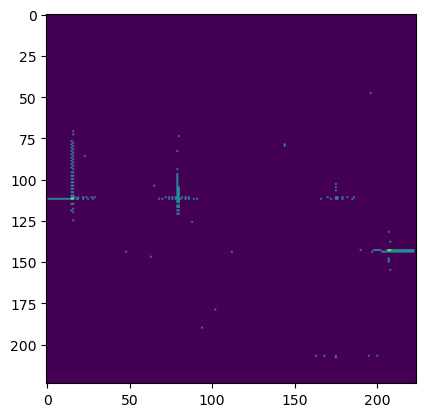

In [230]:
plt.imshow(conv_img.astype(np.uint8))

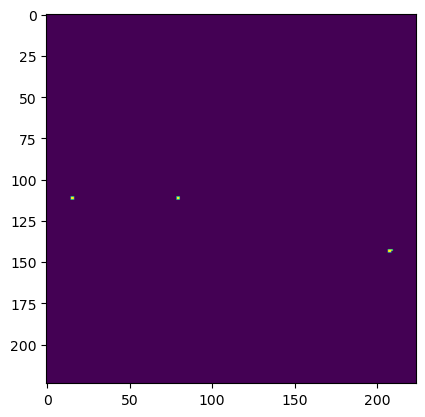

In [231]:

plt.imshow(image)

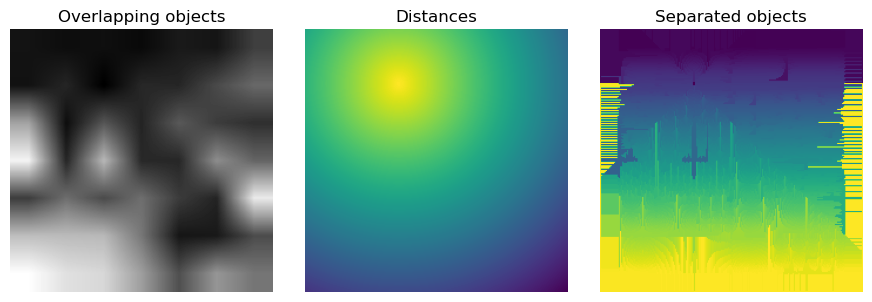

In [233]:
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
mask = conv_img
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance)
ax[1].set_title('Distances')
ax[2].imshow(labels)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
images = []
from glob import glob

image_files = glob('bottle/*.jpg')

# Load and store images in a list
images = [preprocess(Image.open(file)).unsqueeze(0).cpu() for file in image_files]
images = np.stack(images)
images = torch.Tensor(images).squeeze(1).to(device)
texts= ["bottle", "mom", "lion"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(images, text)
probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()